# FULL-DIMENSION DIAGNOSTICS (4 PROBLEMS) – BEFORE CONTRASTIVE LEARNING

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


npz_path = "/kaggle/input/all-features/All_features_FINAL_raw.npz"
data = np.load(npz_path, allow_pickle=True)

X_methyl = data["X_methyl"]         
X_clinical_raw = data["X_clinical"]
clinical_names = data["clinical_feature_names"]

print("\n[STEP 0] Data loaded:")
print(f"  Methylation: {X_methyl.shape}")
print(f"  Clinical:    {X_clinical_raw.shape}")

stage_idx = list(clinical_names).index("stage_clean")
y_raw = X_clinical_raw[:, stage_idx]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)  
stage_names = list(label_encoder.classes_)

print("\n[STEP 0] Labels:")
print(f"  Classes: {stage_names}")
print(f"  Distribution: {np.bincount(y)}")

print(" [STEP 0.5] FILTERING CANCER TYPES (≥10 samples)")


cancer_type_idx = list(clinical_names).index("diagnoses.tissue_or_organ_of_origin")
cancer_types = X_clinical_raw[:, cancer_type_idx]

cancer_counts = pd.Series(cancer_types).value_counts()

print(f"\n BEFORE FILTERING:")
print(f"   Total samples: {len(cancer_types)}")
print(f"   Unique cancer types: {len(cancer_counts)}")

valid_cancers = cancer_counts[cancer_counts >= 10].index.tolist()

print(f"\n   Cancer types with ≥10 samples: {len(valid_cancers)}")
print(f"   Cancer types with <10 samples (removing): {len(cancer_counts) - len(valid_cancers)}")


valid_mask = np.isin(cancer_types, valid_cancers)

X_methyl = X_methyl[valid_mask]
X_clinical_raw = X_clinical_raw[valid_mask]
y = y[valid_mask]
cancer_types = cancer_types[valid_mask]

samples_removed = (~valid_mask).sum()

removed_cancers = cancer_counts[cancer_counts < 10].sort_values(ascending=False)
if len(removed_cancers) > 0:
    print(f"\n   REMOVED CANCER TYPES (n={len(removed_cancers)}):")
    print("   " + "-" * 70)
    for cancer, count in removed_cancers.items():
        print(f"      {cancer:<55} {count:>3} samples")

kept_cancers = cancer_counts[cancer_counts >= 10].sort_values(ascending=False)
print(f"\n   KEPT CANCER TYPES (n={len(kept_cancers)}):")
print("   " + "-" * 70)
for cancer, count in kept_cancers.items():
    print(f"      {cancer:<55} {count:>3} samples")

print(f"\n AFTER FILTERING:")
print(f"   Total samples: {len(cancer_types)} (removed {samples_removed})")
print(f"   Unique cancer types: {len(np.unique(cancer_types))}")
print(f"   Methylation shape: {X_methyl.shape}")
print(f"   Clinical shape: {X_clinical_raw.shape}")
print(f"\n   Stage distribution (after filtering):")
for i, stage_name in enumerate(stage_names):
    count = (y == i).sum()
    pct = count / len(y) * 100
    print(f"      {stage_name}: {count} ({pct:.1f}%)")


# 1) BUILD FULL FEATURE MATRIX: 486,362 CpGs + 13 CLINICAL

clinical_df = pd.DataFrame(X_clinical_raw, columns=clinical_names)

selected_clinical_features = [
    'demographic.gender', 'demographic.vital_status', 'samples.sample_type',
    'cases.disease_type', 'samples.tissue_type', 'diagnoses.primary_diagnosis',
    'diagnoses.tissue_or_organ_of_origin', 'diagnoses.morphology',
    'diagnoses.age_at_diagnosis', 'diagnoses.prior_treatment',
    'diagnoses.prior_malignancy', 'demographic.race', 'demographic.ethnicity'
]

missing = [c for c in selected_clinical_features if c not in clinical_df.columns]
if missing:
    print("\nERROR: Missing clinical features in NPZ:", missing)
    raise KeyError("Missing clinical features in NPZ")

clinical_13 = clinical_df[selected_clinical_features].copy()

for col in clinical_13.columns:
    if clinical_13[col].dtype == object:
        le = LabelEncoder()
        clinical_13[col] = le.fit_transform(clinical_13[col].astype(str))

X_clinical = clinical_13.values.astype(np.float64)

X_full = np.hstack([X_methyl.astype(np.float64), X_clinical])

print("\n[STEP 1] Full feature matrix:")
print(f"  Shape: {X_full.shape}  (CpG + 13 clinical)")
print(f"  CpG features: {X_methyl.shape[1]}")
print(f"  Clinical features: {X_clinical.shape[1]}")


print("\n[STEP 2] Scaling full features")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full).astype(np.float64)

print(f"  Scaled matrix: {X_scaled.shape}")
print(f"  Approx memory: {X_scaled.nbytes / (1024**3):.2f} GB")

print("PROBLEM 1: Class Separability")


centroids = []
for k in range(3):
    mask = (y == k)
    centroid = X_scaled[mask].mean(axis=0, keepdims=True)
    centroids.append(centroid)

centroids = np.vstack(centroids)        
sim_mat = cosine_similarity(centroids)  

s12 = sim_mat[0, 1]
s13 = sim_mat[0, 2]
s23 = sim_mat[1, 2]

print("\n   Pairwise Cosine Similarity (full feature space):")
print(f"   {stage_names[0]} vs {stage_names[1]}: {s12*100:.1f}% similar")
print(f"   {stage_names[0]} vs {stage_names[2]}: {s13*100:.1f}% similar")
print(f"   {stage_names[1]} vs {stage_names[2]}: {s23*100:.1f}% similar")

avg_sim = (s12 + s13 + s23) / 3
print(f"\n    Average similarity: {avg_sim*100:.1f}%")
if avg_sim < 0:
    print("     Classes point in opposite directions (good separability).")
else:
    print("     Classes share similar directions (more overlap).")


print("PROBLEM 2: Feature Information Content (PCA)")

n_components = 100  
pca = PCA(n_components=n_components, random_state=42)
pca.fit(X_scaled)

var_ratio = pca.explained_variance_ratio_
cum_var = np.cumsum(var_ratio)

k80 = np.searchsorted(cum_var, 0.80) + 1
k95 = np.searchsorted(cum_var, 0.95) + 1

print(f"\n   Variance Analysis (first {n_components} components):")
print(f"   Components for 80% variance: {k80}/{n_components}")
print(f"   Components for 95% variance: {k95}/{n_components}")

if k80 < n_components:
    print(f"\n    WARNING: Only {k80} components (of first {n_components}) needed for 80% variance")
    print("     Many of the 486,375 features are redundant/noisy.")
else:
    print("\n    INFO: 80% variance not reached within first "
          f"{n_components} components (variance more spread out).")


print("PROBLEM 3: Stage II–III Discrimination")

idx_stage2 = list(label_encoder.classes_).index('Stage II')
idx_stage3 = list(label_encoder.classes_).index('Stage III')

X2 = X_scaled[y == idx_stage2]
X3 = X_scaled[y == idx_stage3]

cent2 = X2.mean(axis=0, keepdims=True)
cent3 = X3.mean(axis=0, keepdims=True)
sim_23 = cosine_similarity(cent2, cent3)[0, 0]

print(f"\n   {stage_names[idx_stage2]} vs {stage_names[idx_stage3]} centroid similarity: {sim_23*100:.2f}%")

if sim_23 < 0.2:
    print("     Stages II and III are fairly distinct in full space.")
elif sim_23 < 0.8:
    print("     Moderate similarity: noticeable overlap between Stage II and III.")
else:
    print("     High similarity: Stage II and III heavily overlap in full space.")


print("PROBLEM 4: VAE Compression Loss (Comparison)")

original_cpg = X_methyl.shape[1]   
latent_dim = 150                  
compression_ratio = original_cpg / latent_dim
info_retained = latent_dim / original_cpg

print(f"\n   Original CpG sites: {original_cpg}")
print(f"   VAE latent features (before): {latent_dim}")
print(f"   Compression ratio: {compression_ratio:.1f}:1")
print(f"   Approx. fraction of dimensions retained: {info_retained*100:.4f}%")

print("\n   In this full-dimension run (current):")
print(f"   We keep all {original_cpg} CpG features (no compression).")
print("    0% dimensionality reduction on methylation features.")
print("    Any loss will now come from the model, not from VAE encoding.")

print(" FULL-DIMENSION DIAGNOSTICS COMPLETE")

print(f"\n Analyzed {len(kept_cancers)} well-represented cancer types")
print(f" Total samples: {len(cancer_types)}")
print(f" Removed {samples_removed} samples from rare cancers")




[STEP 0] Data loaded:
  Methylation: (2624, 486362)
  Clinical:    (2624, 21)

[STEP 0] Labels:
  Classes: ['Stage I', 'Stage II', 'Stage III']
  Distribution: [929 978 717]
 [STEP 0.5] FILTERING CANCER TYPES (≥10 samples)

 BEFORE FILTERING:
   Total samples: 2624
   Unique cancer types: 65

   Cancer types with ≥10 samples: 34
   Cancer types with <10 samples (removing): 31

   REMOVED CANCER TYPES (n=31):
   ----------------------------------------------------------------------
      Floor of mouth, NOS                                       9 samples
      Descending colon                                          9 samples
      Anterior wall of bladder                                  8 samples
      Transverse colon                                          8 samples
      Body of pancreas                                          7 samples
      Base of tongue, NOS                                       7 samples
      Dome of bladder                                           7 sam

# PRODUCTION FULL-DIMENSION CONTRASTIVE LEARNING

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, mixed_precision
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import gc
import warnings
warnings.filterwarnings('ignore')

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(" GPU configured")
    except:
        pass

print("\n[1] Loading data...")
npz_path = "/kaggle/input/all-features/All_features_FINAL_raw.npz"
data = np.load(npz_path, allow_pickle=True)

X_methyl = data["X_methyl"].astype(np.float32)
X_clinical_raw = data["X_clinical"]
clinical_names = data["clinical_feature_names"]

stage_idx = list(clinical_names).index("stage_clean")
y = LabelEncoder().fit_transform(X_clinical_raw[:, stage_idx])

clinical_df = pd.DataFrame(X_clinical_raw, columns=clinical_names)
selected = [
    'demographic.gender', 'demographic.vital_status', 'samples.sample_type',
    'cases.disease_type', 'samples.tissue_type', 'diagnoses.primary_diagnosis',
    'diagnoses.tissue_or_organ_of_origin', 'diagnoses.morphology',
    'diagnoses.age_at_diagnosis', 'diagnoses.prior_treatment',
    'diagnoses.prior_malignancy', 'demographic.race', 'demographic.ethnicity'
]

clinical_13 = clinical_df[selected].copy()
for col in clinical_13.columns:
    if clinical_13[col].dtype == object:
        clinical_13[col] = LabelEncoder().fit_transform(clinical_13[col].astype(str))

X_full = np.hstack([X_methyl, clinical_13.values.astype(np.float32)])
X_scaled = StandardScaler().fit_transform(X_full).astype(np.float32)

print(f"   Data: {X_scaled.shape}, Memory: ~{X_scaled.nbytes/(1024**3):.1f}GB")

del X_methyl, X_clinical_raw, X_full
gc.collect()

print("\n[2] Creating data pipeline")

class_indices = {c: np.where(y == c)[0] for c in range(3)}

def triplet_generator():
    """Python generator for triplets"""
    while True:
        c_anchor = np.random.randint(0, 3)
        idx_a = np.random.choice(class_indices[c_anchor])
        
        same = class_indices[c_anchor]
        idx_p = np.random.choice(same)
        while idx_p == idx_a and len(same) > 1:
            idx_p = np.random.choice(same)
        
        c_neg = np.random.choice([c for c in range(3) if c != c_anchor])
        idx_n = np.random.choice(class_indices[c_neg])
        
        yield (X_scaled[idx_a], X_scaled[idx_p], X_scaled[idx_n])

output_signature = (
    tf.TensorSpec(shape=(486375,), dtype=tf.float32),
    tf.TensorSpec(shape=(486375,), dtype=tf.float32),
    tf.TensorSpec(shape=(486375,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    triplet_generator,
    output_signature=output_signature
)

batch_size = 8
steps_per_epoch = 200
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

print(f"   Batch: {batch_size}, Steps/epoch: {steps_per_epoch}")

print("\n[3] Building model")

def build_encoder(input_dim):
    inp = keras.Input(shape=(input_dim,), dtype=tf.float32)
    x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation=None, dtype=tf.float32)(x)
    out = layers.Lambda(lambda t: tf.nn.l2_normalize(tf.cast(t, tf.float32), axis=1))(x)
    return keras.Model(inp, out)

class TripletModel(keras.Model):
    def __init__(self, encoder, margin=0.5):
        super().__init__()
        self.encoder = encoder
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")
    
    def call(self, inputs):
        anchor, positive, negative = inputs
        return (self.encoder(anchor), 
                self.encoder(positive), 
                self.encoder(negative))
    
    def train_step(self, data):
        anchor, positive, negative = data
        
        with tf.GradientTape() as tape:
            anchor_emb = self.encoder(anchor, training=True)
            positive_emb = self.encoder(positive, training=True)
            negative_emb = self.encoder(negative, training=True)
            
            pos_dist = tf.reduce_sum(tf.square(anchor_emb - positive_emb), axis=1)
            neg_dist = tf.reduce_sum(tf.square(anchor_emb - negative_emb), axis=1)
            loss = tf.reduce_mean(tf.maximum(pos_dist - neg_dist + self.margin, 0.0))
        
        grads = tape.gradient(loss, self.encoder.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.encoder.trainable_variables))
        self.loss_tracker.update_state(loss)
        
        return {"loss": self.loss_tracker.result()}
    
    @property
    def metrics(self):
        return [self.loss_tracker]

encoder = build_encoder(486375)
model = TripletModel(encoder, margin=0.5)

optimizer = keras.optimizers.Adam(1e-4)
optimizer = mixed_precision.LossScaleOptimizer(optimizer)
model.compile(optimizer=optimizer)

print(f"   Params: {encoder.count_params():,}")

# TRAIN
print("\n[4] Training")


history = model.fit(
    dataset,
    epochs=50,
    steps_per_epoch=steps_per_epoch,
    verbose=2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(
            monitor='loss', factor=0.5, patience=7, min_lr=1e-7, verbose=1
        )
    ]
)

print("\n Training complete!")

# EXTRACT & EVALUATE
print("\n[5] Extracting embeddings")
X_contrastive = encoder.predict(X_scaled, batch_size=256, verbose=0)

old_c2 = X_scaled[y == 1].mean(axis=0, keepdims=True)
old_c3 = X_scaled[y == 2].mean(axis=0, keepdims=True)
old_sim = cosine_similarity(old_c2, old_c3)[0, 0]

new_c2 = X_contrastive[y == 1].mean(axis=0, keepdims=True)
new_c3 = X_contrastive[y == 2].mean(axis=0, keepdims=True)
new_sim = cosine_similarity(new_c2, new_c3)[0, 0]

mask = (y == 1) | (y == 2)
lda_old = LinearDiscriminantAnalysis()
lda_old.fit(X_scaled[mask], y[mask])
old_acc = lda_old.score(X_scaled[mask], y[mask])

lda_new = LinearDiscriminantAnalysis()
lda_new.fit(X_contrastive[mask], y[mask])
new_acc = lda_new.score(X_contrastive[mask], y[mask])

print(" RESULTS: FULL-DIMENSION CONTRASTIVE LEARNING")

print(f"\n Stage II vs III Similarity:")
print(f"   BEFORE: {old_sim*100:6.2f}%")
print(f"   AFTER:  {new_sim*100:6.2f}%")
print(f"   Δ:      {(old_sim - new_sim)*100:6.2f} pp reduction")

print(f"\n LDA Accuracy (II vs III):")
print(f"   BEFORE: {old_acc*100:6.1f}%")
print(f"   AFTER:  {new_acc*100:6.1f}%")
print(f"   Δ:      {(new_acc - old_acc)*100:+6.1f}%")

if new_sim < 0.1:
    verdict = "EXCELLENT"
elif new_sim < 0.25:
    verdict = "GOOD"
else:
    verdict = "MODERATE"

print(f"\nVerdict: {verdict}")

# Save
np.save('/kaggle/working/X_contrastive_512_full.npy', X_contrastive)
np.save('/kaggle/working/X_scaled_full.npy', X_scaled)
np.save('/kaggle/working/y_full.npy', y)
encoder.save('/kaggle/working/encoder_512_full.keras')

print("\n✓ Saved all files to /kaggle/working/")
print("\nFiles:")
print("  X_contrastive_512_full.npy")
print("  X_scaled_full.npy")
print("  y_full.npy")
print("  encoder_512_full.keras")


 GPU configured

[1] Loading data...
   Data: (2624, 486375), Memory: ~4.8GB

[2] Creating data pipeline


I0000 00:00:1764794163.784948      78 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79020 MB memory:  -> device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:04:00.0, compute capability: 9.0


   Batch: 8, Steps/epoch: 200

[3] Building model
   Params: 249,175,360

[4] Training
Epoch 1/50


I0000 00:00:1764794167.092118     662 service.cc:148] XLA service 0x7805e4002f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764794167.092781     662 service.cc:156]   StreamExecutor device (0): NVIDIA H100 80GB HBM3, Compute Capability 9.0
I0000 00:00:1764794167.494554     662 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1764794170.734611     662 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 - 8s - 42ms/step - loss: 0.5221 - learning_rate: 1.0000e-04
Epoch 2/50
200/200 - 2s - 11ms/step - loss: 0.5446 - learning_rate: 1.0000e-04
Epoch 3/50
200/200 - 2s - 11ms/step - loss: 0.5055 - learning_rate: 1.0000e-04
Epoch 4/50
200/200 - 2s - 11ms/step - loss: 0.5136 - learning_rate: 1.0000e-04
Epoch 5/50
200/200 - 2s - 11ms/step - loss: 0.5004 - learning_rate: 1.0000e-04
Epoch 6/50
200/200 - 2s - 11ms/step - loss: 0.4878 - learning_rate: 1.0000e-04
Epoch 7/50
200/200 - 2s - 11ms/step - loss: 0.4861 - learning_rate: 1.0000e-04
Epoch 8/50
200/200 - 2s - 11ms/step - loss: 0.4798 - learning_rate: 1.0000e-04
Epoch 9/50
200/200 - 2s - 11ms/step - loss: 0.5111 - learning_rate: 1.0000e-04
Epoch 10/50
200/200 - 2s - 11ms/step - loss: 0.5031 - learning_rate: 1.0000e-04
Epoch 11/50
200/200 - 2s - 11ms/step - loss: 0.4940 - learning_rate: 1.0000e-04
Epoch 12/50
200/200 - 2s - 11ms/step - loss: 0.4846 - learning_rate: 1.0000e-04
Epoch 13/50
200/200 - 2s - 11ms/step - loss: 0.4848 - learni

# COMPREHENSIVE CONTRASTIVE LEARNING EVALUATION

In [6]:
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

print("\n[1] Loading saved embeddings")

X_scaled = np.load('/kaggle/working/X_scaled_full.npy')
X_contrastive = np.load('/kaggle/working/X_contrastive_512_full.npy')
y = np.load('/kaggle/working/y_full.npy')

print(f"   Original features: {X_scaled.shape}")
print(f"   Contrastive embeddings: {X_contrastive.shape}")
print(f"   Labels: {y.shape}")


print("\n[2] Computing metrics...")

stage2_mask = (y == 1)
stage3_mask = (y == 2)

old_c2 = X_scaled[stage2_mask].mean(axis=0, keepdims=True)
old_c3 = X_scaled[stage3_mask].mean(axis=0, keepdims=True)
old_sim = abs(cosine_similarity(old_c2, old_c3)[0, 0])

new_c2 = X_contrastive[stage2_mask].mean(axis=0, keepdims=True)
new_c3 = X_contrastive[stage3_mask].mean(axis=0, keepdims=True)
new_sim = abs(cosine_similarity(new_c2, new_c3)[0, 0])

sample_size = min(1500, len(y))
sample_idx = np.random.choice(len(y), size=sample_size, replace=False)

old_silhouette = silhouette_score(X_scaled[sample_idx], y[sample_idx])
new_silhouette = silhouette_score(X_contrastive[sample_idx], y[sample_idx])

old_davies = davies_bouldin_score(X_scaled[sample_idx], y[sample_idx])
new_davies = davies_bouldin_score(X_contrastive[sample_idx], y[sample_idx])

old_calinski = calinski_harabasz_score(X_scaled[sample_idx], y[sample_idx])
new_calinski = calinski_harabasz_score(X_contrastive[sample_idx], y[sample_idx])

mask_23 = (y == 1) | (y == 2)

lda_old = LinearDiscriminantAnalysis()
lda_old.fit(X_scaled[mask_23], y[mask_23])
old_lda = lda_old.score(X_scaled[mask_23], y[mask_23])

lda_new = LinearDiscriminantAnalysis()
lda_new.fit(X_contrastive[mask_23], y[mask_23])
new_lda = lda_new.score(X_contrastive[mask_23], y[mask_23])

print(" CONTRASTIVE LEARNING RESULTS")

print(f"\nStage II-III Similarity:")
print(f"   Original: {old_sim:.4f}")
print(f"   Contrastive: {new_sim:.4f}")
print(f"   Improvement: {old_sim - new_sim:+.4f} (lower is better)")

print(f"\nSilhouette Score:")
print(f"   Original: {old_silhouette:.4f}")
print(f"   Contrastive: {new_silhouette:.4f}")
print(f"   Improvement: {new_silhouette - old_silhouette:+.4f}")

print(f"\nDavies-Bouldin Index:")
print(f"   Original: {old_davies:.4f}")
print(f"   Contrastive: {new_davies:.4f}")
print(f"   Improvement: {old_davies - new_davies:.4f} (lower is better)")

print(f"\nCalinski-Harabasz Score:")
print(f"   Original: {old_calinski:.4f}")
print(f"   Contrastive: {new_calinski:.4f}")
print(f"   Improvement: {new_calinski / old_calinski:.1f}x better")

print(f"\nLDA Score (II vs III):")
print(f"   Original: {old_lda:.4f}")
print(f"   Contrastive: {new_lda:.4f}")
print(f"   Improvement: {new_lda - old_lda:+.4f}")

import pandas as pd

metrics_df = pd.DataFrame({
    'Metric': [
        'Stage II-III Similarity',
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Calinski-Harabasz Score',
        'LDA Score (II vs III)'
    ],
    'Original': [old_sim, old_silhouette, old_davies, old_calinski, old_lda],
    'Contrastive': [new_sim, new_silhouette, new_davies, new_calinski, new_lda],
    'Improvement': [
        old_sim - new_sim,
        new_silhouette - old_silhouette,
        old_davies - new_davies,
        new_calinski / old_calinski,
        new_lda - old_lda
    ]
})

metrics_df.to_csv('/kaggle/working/contrastive_metrics.csv', index=False)
print("\n Saved metrics to: /kaggle/working/contrastive_metrics.csv")



[1] Loading saved embeddings
   Original features: (2624, 486375)
   Contrastive embeddings: (2624, 64)
   Labels: (2624,)

[2] Computing metrics...
 CONTRASTIVE LEARNING RESULTS

Stage II-III Similarity:
   Original: 0.3968
   Contrastive: 0.9214
   Improvement: -0.5247 (lower is better)

Silhouette Score:
   Original: -0.0094
   Contrastive: 0.0182
   Improvement: +0.0276

Davies-Bouldin Index:
   Original: 15.3350
   Contrastive: 7.2393
   Improvement: 8.0958 (lower is better)

Calinski-Harabasz Score:
   Original: 7.3199
   Contrastive: 80.0428
   Improvement: 10.9x better

LDA Score (II vs III):
   Original: 0.8844
   Contrastive: 0.6755
   Improvement: -0.2088

 Saved metrics to: /kaggle/working/contrastive_metrics.csv


# DRIFTNET FULL-DIMENSION CLASSIFIER (486K+ FEATURES)

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

tf.keras.backend.set_floatx('float64')
print("Precision set to: float64")

print(" DRIFTNET FULL-DIMENSION CLASSIFIER (486K+ FEATURES)")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

npz_path = "/kaggle/input/all-features/All_features_FINAL_cleaned_filtered.npz"
data = np.load(npz_path, allow_pickle=True)

X_methyl = data["X_methyl"]               
X_clinical_raw = data["X_clinical"]     
clinical_names = data["clinical_feature_names"]

print("\n[STEP 1] Data loaded:")
print(f"  Methylation: {X_methyl.shape}")
print(f"  Clinical: {X_clinical_raw.shape}")
print(f"  Total samples: {X_methyl.shape[0]}")

stage_idx = list(clinical_names).index("stage_clean")
y_raw = X_clinical_raw[:, stage_idx]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print(f"\n[STEP 2] Labels extracted:")
print(f"  Classes: {label_encoder.classes_}")
print(f"  Distribution: {np.bincount(y)}")

clinical_df = pd.DataFrame(X_clinical_raw, columns=clinical_names)

print("\n[STEP 3] Clinical columns in NPZ:")
print(list(clinical_df.columns))

label_col = "stage_clean"

selected_clinical_features = [
    'demographic.gender', 'demographic.vital_status', 'samples.sample_type',
    'cases.disease_type', 'samples.tissue_type', 'diagnoses.primary_diagnosis',
    'diagnoses.tissue_or_organ_of_origin', 'diagnoses.morphology',
    'diagnoses.age_at_diagnosis', 'diagnoses.prior_treatment',
    'diagnoses.prior_malignancy', 'demographic.race', 'demographic.ethnicity'
]

missing = [c for c in selected_clinical_features if c not in clinical_df.columns]
if missing:
    print("\nERROR: These selected clinical features are missing in NPZ:")
    print(missing)
    raise KeyError("Missing clinical features in NPZ")

clinical_13 = clinical_df[selected_clinical_features].copy()

for col in clinical_13.columns:
    if clinical_13[col].dtype == object:
        le = LabelEncoder()
        clinical_13[col] = le.fit_transform(clinical_13[col].astype(str))

X_clinical = clinical_13.values.astype(np.float64)

print(f"\n[STEP 3] Final clinical feature matrix:")
print(f"  Shape: {X_clinical.shape}")
print(f"  Features used: {list(clinical_13.columns)}")

X_full = np.hstack([X_methyl.astype(np.float64), X_clinical])

print(f"\n[STEP 4] Full feature matrix created:")
print(f"  Shape: {X_full.shape}")
print(f"  Methylation: {X_methyl.shape[1]} features")
print(f"  Clinical (used): {X_clinical.shape[1]} features")
print(f"  Total: {X_full.shape[1]} features")


print("\n[STEP 5] Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full).astype(np.float64)

print(f"  Scaled matrix: {X_scaled.shape}")
print(f"  Memory usage: ~{X_scaled.nbytes / (1024**3):.2f} GB")

X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.40, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"\n[STEP 6] Data split:")
print(f"  Train: {X_train.shape[0]} samples")
print(f"  Val:   {X_val.shape[0]} samples")
print(f"  Test:  {X_test.shape[0]} samples")

cw = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_weights = {i: w for i, w in enumerate(cw)}

print(f"\n[STEP 7] Class weights computed:")
for i, w in class_weights.items():
    print(f"  Stage {label_encoder.classes_[i]}: {w:.3f}")

def build_full_dimension_driftnet(input_dim, num_classes=3):
    inp = keras.Input(shape=(input_dim,), dtype=tf.float64)

    x = layers.Dense(512, activation="relu",
                     kernel_regularizer=keras.regularizers.l2(1e-4),
                     dtype=tf.float64)(inp)
    x = layers.BatchNormalization(dtype=tf.float64)(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=keras.regularizers.l2(1e-4),
                     dtype=tf.float64)(x)
    x = layers.BatchNormalization(dtype=tf.float64)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=keras.regularizers.l2(1e-4),
                     dtype=tf.float64)(x)
    x = layers.BatchNormalization(dtype=tf.float64)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(64, activation="relu",
                     kernel_regularizer=keras.regularizers.l2(1e-4),
                     dtype=tf.float64)(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(num_classes, activation="softmax", dtype=tf.float64)(x)
    return keras.Model(inp, out)


def focal_loss(gamma=2.0, alpha=0.25, label_smoothing=0.1):
    """
    Focal loss with label smoothing to prevent overconfidence.
    """
    def loss_fn(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_onehot = tf.one_hot(y_true, 3, dtype=tf.float64)
        
        # Apply label smoothing
        y_onehot = y_onehot * (1.0 - label_smoothing) + label_smoothing / 3.0
        
        eps = 1e-10
        y_pred = tf.clip_by_value(y_pred, eps, 1.0 - eps)
        
        ce = -tf.reduce_sum(y_onehot * tf.math.log(y_pred), axis=-1)
        pt = tf.reduce_sum(y_onehot * y_pred, axis=-1)
        
        focal_weight = alpha * tf.pow(1.0 - pt, gamma)
        return tf.reduce_mean(focal_weight * ce)
    
    return loss_fn

print(f"\n[STEP 8] Building DriftNet model...")

model = build_full_dimension_driftnet(X_scaled.shape[1])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.25, label_smoothing=0.1),
    metrics=["accuracy"]
)

print(f"\nModel summary:")
model.summary()

total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")
print(f"Estimated model size (float64): ~{total_params * 8 / (1024**3):.2f} GB")
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),
    
    keras.callbacks.ModelCheckpoint(
        "driftnet_full_dim_best.h5",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),
    
    keras.callbacks.CSVLogger("training_log.csv")
]
print(f"\n[STEP 9] Training DriftNet (float64 precision)...")
print(f"  Batch size: 16 (optimized for 486K features)")
print(f"  Max epochs: 100")
print(f"  Early stopping patience: 15")
print(f"  NOTE: float64 will use ~2x more memory than float32")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)



Precision set to: float64
 DRIFTNET FULL-DIMENSION CLASSIFIER (486K+ FEATURES)
TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[STEP 1] Data loaded:
  Methylation: (2503, 486362)
  Clinical: (2503, 21)
  Total samples: 2503

[STEP 2] Labels extracted:
  Classes: ['Stage I' 'Stage II' 'Stage III']
  Distribution: [911 927 665]

[STEP 3] Clinical columns in NPZ:
['stage_clean', 'methylation_sample_id', 'File ID', 'Case ID', 'Sample ID', 'Project ID', 'demographic.gender', 'demographic.vital_status', 'samples.sample_type', 'cases.disease_type', 'samples.tissue_type', 'diagnoses.primary_diagnosis', 'diagnoses.tissue_or_organ_of_origin', 'diagnoses.morphology', 'diagnoses.age_at_diagnosis', 'diagnoses.prior_treatment', 'diagnoses.prior_malignancy', 'demographic.race', 'demographic.ethnicity', 'cleaned_data_sample_id', 'methylation id']

[STEP 3] Final clinical feature matrix:
  Shape: (2503, 13)
  Features used: ['demographic.gen

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 486375)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │   249,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_11 (Cast)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_12 (Cast)                  │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_13 (Cast)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_14 (Cast)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_15 (Cast)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_16 (Cast)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_17 (Cast)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_18 (Cast)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 249,200,771 (1.86 GB)

 Trainable params: 249,198,979 (1.86 GB)

 Non-trainable params: 1,792 (14.00 KB)


Total parameters: 249,200,771
Estimated model size (float64): ~1.86 GB

[STEP 9] Training DriftNet (float64 precision)...
  Batch size: 16 (optimized for 486K features)
  Max epochs: 100
  Early stopping patience: 15
  NOTE: float64 will use ~2x more memory than float32
Epoch 1/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3397 - loss: 0.4874
Epoch 1: val_accuracy improved from -inf to 0.49301, saving model to driftnet_full_dim_best.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 0.3399 - loss: 0.4871 - val_accuracy: 0.4930 - val_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3915 - loss: 0.4101
Epoch 2: val_accuracy improved from 0.49301 to 0.51497, saving model to driftnet_full_dim_best.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.3915 - loss: 0.4101 - val_accuracy: 0.5150 - val_loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4040 - loss: 0.4001
Epoch 3: val_accuracy did not improve from 0.51497
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4040 - loss: 0.4002 - val_accuracy: 0.5110 - val_loss: 0.3065 - learning_rate: 1.0000e-04
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4322 - loss: 0.3938
Epoch 4: val_accuracy improved from 0.51497 to 0.55090, saving model to driftnet_full_dim_best.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.4322 - loss: 0.3938 - val_accuracy: 0.5509 - val_loss: 0.3109 - learning_rate: 1.0000e-04
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4245 - loss: 0.3807
Epoch 5: val_accuracy did not improve from 0.55090
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4245 - loss: 0.3807 - val_accuracy: 0.5369 - val_loss: 0.3164 - learning_rate: 1.0000e-04
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4256 - loss: 0.3797
Epoch 6: val_accuracy did not improve from 0.55090
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4256 - loss: 0.3796 - val_accuracy: 0.5349 - val_loss: 0.3083 - learning_rate: 1.0000e-04
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4445 - loss: 0.3755
Epoch 7: val_accuracy did not improve from 0.55090
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.4446 - loss: 0.3754 - val_accuracy: 0.5449 - val_loss: 0.3054 - learning_rate: 1.0000e-04
Epoch 8/100


[STEP 10] Loading best model and evaluating...
 FINAL TEST RESULTS
Test Accuracy: 53.69%
Test Loss: 0.3024
 CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Stage I     0.6606    0.5956    0.6264       183
    Stage II     0.4813    0.8324    0.6099       185
   Stage III     0.3750    0.0451    0.0805       133

    accuracy                         0.5369       501
   macro avg     0.5056    0.4911    0.4390       501
weighted avg     0.5186    0.5369    0.4754       501

 CONFUSION MATRIX
[[109  72   2]
 [ 23 154   8]
 [ 33  94   6]]


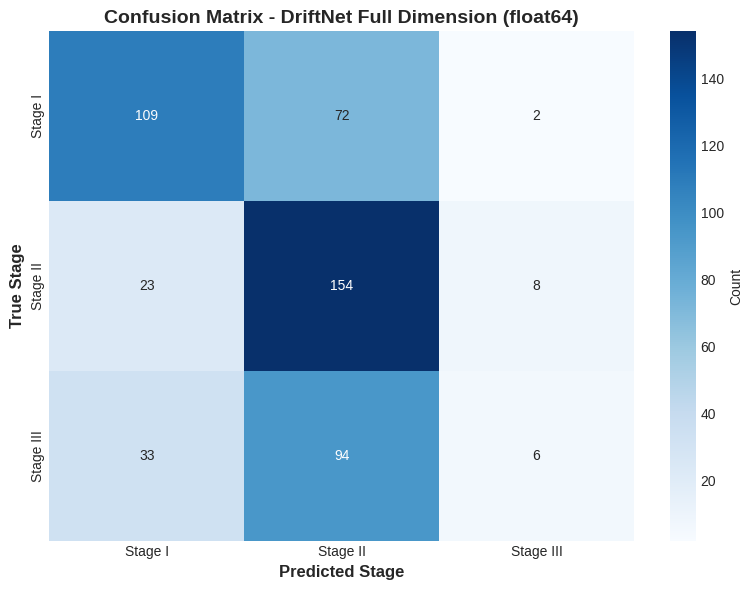

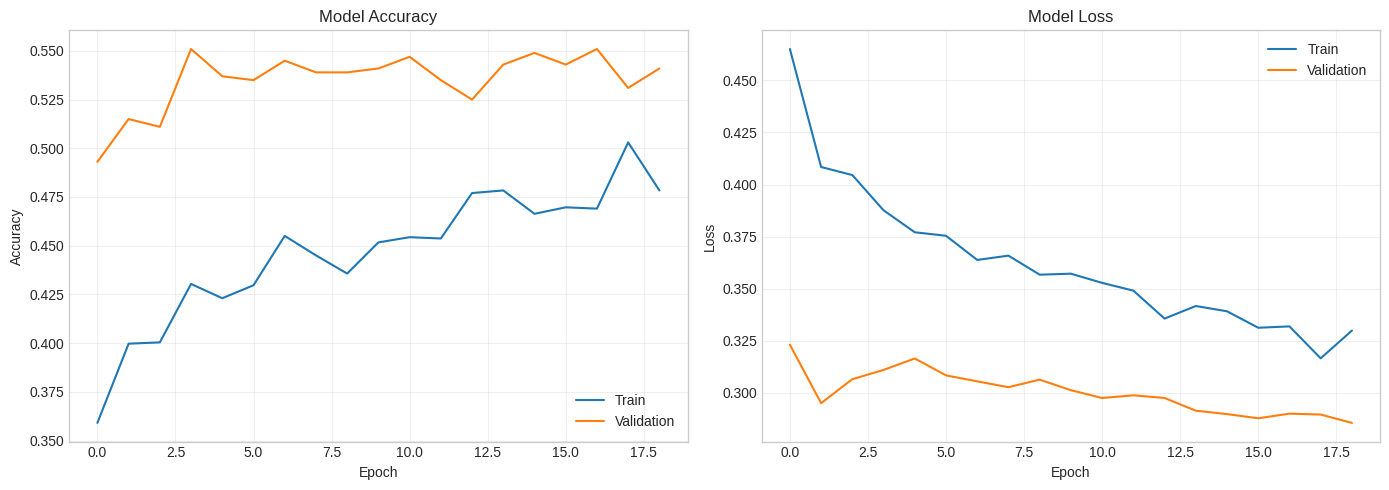

 PER-CLASS ACCURACY
Stage I: 59.56% (183 samples)
Stage II: 83.24% (185 samples)
Stage III: 4.51% (133 samples)
 TRAINING COMPLETE!

Saved files:
  • driftnet_full_dim_best.h5
  • training_log.csv
  • confusion_matrix_full_dim.png
  • training_history_full_dim.png


In [15]:
print("\n[STEP 10] Loading best model and evaluating...")

keras.callbacks.ModelCheckpoint(
    "driftnet_full_dim_best.keras",
    monitor="val_accuracy",
    save_best_only=True
)


model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=focal_loss(),
    metrics=["accuracy"]
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

print(" FINAL TEST RESULTS")
print(f"Test Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

print(" CLASSIFICATION REPORT")
print(classification_report(
    y_test, y_pred,
    target_names=label_encoder.classes_,
    digits=4
))

cm = confusion_matrix(y_test, y_pred)
print(" CONFUSION MATRIX")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - DriftNet Full Dimension (float64)', fontsize=14, fontweight='bold')
plt.ylabel('True Stage', fontsize=12, fontweight='bold')
plt.xlabel('Predicted Stage', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix_full_dim.png', dpi=300)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_full_dim.png', dpi=300)
plt.show()

print(" PER-CLASS ACCURACY")
for i, stage in enumerate(label_encoder.classes_):
    mask = (y_test == i)
    class_acc = accuracy_score(y_test[mask], y_pred[mask])
    print(f"{stage}: {class_acc * 100:.2f}% ({mask.sum()} samples)")

print(" TRAINING COMPLETE!")
print("\nSaved files:")
print("  • driftnet_full_dim_best.h5")
print("  • training_log.csv")
print("  • confusion_matrix_full_dim.png")
print("  • training_history_full_dim.png")


# Evaluation

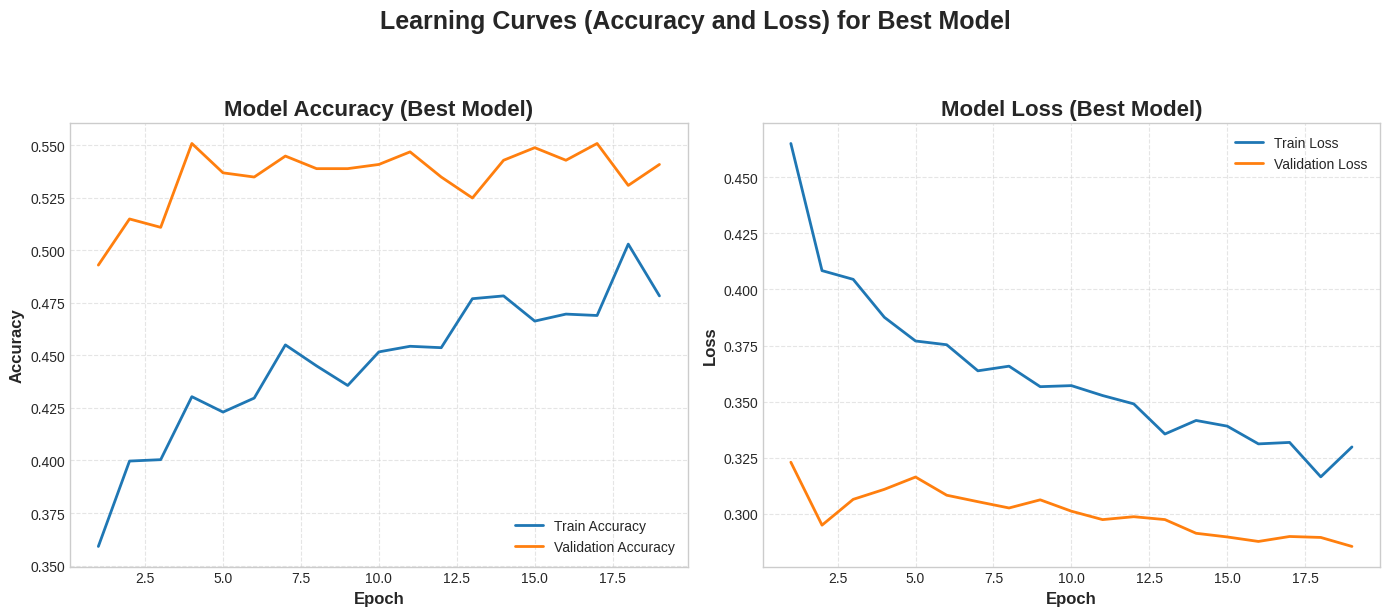

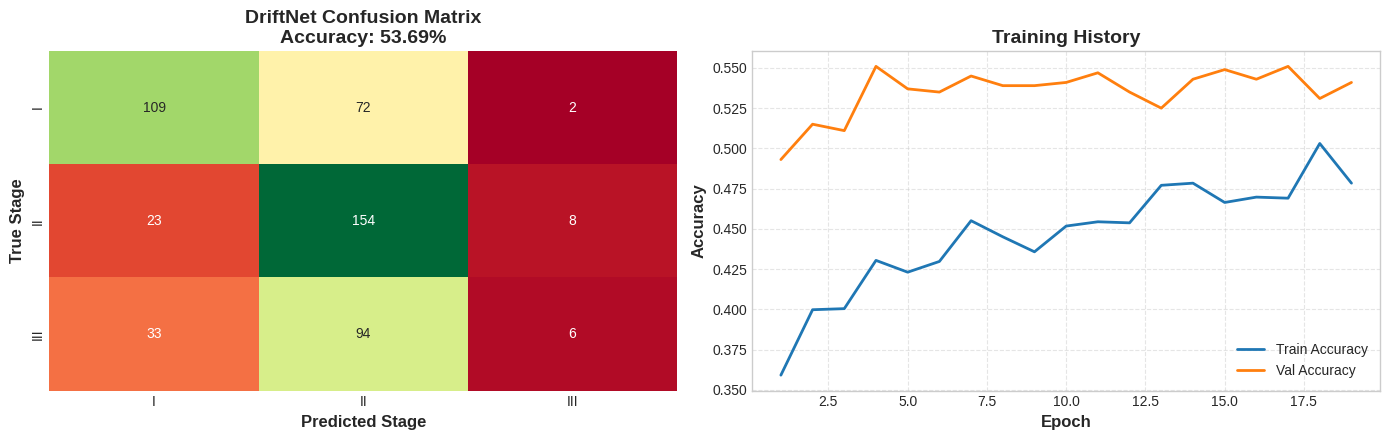

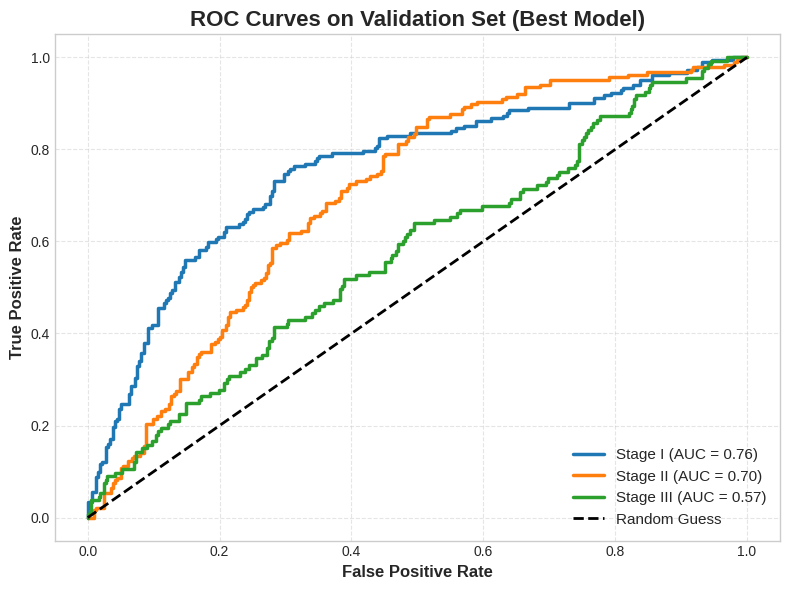

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'
plt.style.use('seaborn-v0_8-whitegrid')

stage_names = ['Stage I', 'Stage II', 'Stage III']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

epochs = range(1, len(history.history['accuracy']) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("Learning Curves (Accuracy and Loss) for Best Model",
             fontsize=18, fontweight='bold', y=1.02)
ax = axes[0]
ax.plot(epochs, history.history['accuracy'],
        label='Train Accuracy', color='#1f77b4', linewidth=2)
ax.plot(epochs, history.history['val_accuracy'],
        label='Validation Accuracy', color='#ff7f0e', linewidth=2)
ax.set_title("Model Accuracy (Best Model)", fontsize=16, fontweight='bold')
ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(epochs, history.history['loss'],
        label='Train Loss', color='#1f77b4', linewidth=2)
ax.plot(epochs, history.history['val_loss'],
        label='Validation Loss', color='#ff7f0e', linewidth=2)
ax.set_title("Model Loss (Best Model)", fontsize=16, fontweight='bold')
ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax.set_ylabel("Loss", fontsize=12, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("/kaggle/working/LC_FULL_BEST.png", bbox_inches='tight')
plt.show()

cm = confusion_matrix(y_test, y_pred)
test_acc = accuracy_score(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 4.5))

ax = axes[0]
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn',
            xticklabels=['I', 'II', 'III'],
            yticklabels=['I', 'II', 'III'],
            cbar=False, ax=ax)
ax.set_xlabel("Predicted Stage", fontsize=12, fontweight='bold')
ax.set_ylabel("True Stage", fontsize=12, fontweight='bold')
ax.set_title(f"DriftNet Confusion Matrix\nAccuracy: {test_acc*100:.2f}%",
             fontsize=14, fontweight='bold')

ax = axes[1]
ax.plot(epochs, history.history['accuracy'],
        label='Train Accuracy', color='#1f77b4', linewidth=2)
ax.plot(epochs, history.history['val_accuracy'],
        label='Val Accuracy', color='#ff7f0e', linewidth=2)
ax.set_title("Training History", fontsize=14, fontweight='bold')
ax.set_xlabel("Epoch", fontsize=12, fontweight='bold')
ax.set_ylabel("Accuracy", fontsize=12, fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("/kaggle/working/CM_PLUS_HISTORY_FULL.png", bbox_inches='tight')
plt.show()

y_val_proba = model.predict(X_val, verbose=0)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_bin.shape[1]

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2.5, color=colors[i],
             label=f"{stage_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

plt.xlabel("False Positive Rate", fontsize=12, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=12, fontweight='bold')
plt.title("ROC Curves on Validation Set (Best Model)",
          fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("/kaggle/working/ROC_FULL_BEST.png", bbox_inches='tight')
plt.show()
